In [1]:
import scanpy as sc
import anndata as ann
import numpy as np 
import seaborn as sb
import pandas as pd
import pickle
from sklearn import preprocessing as pp
import diffxpy.api as de
import time
from scipy import sparse
import glob

import sys  
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/mm_pancreas_atlas_rep/code/')
from importlib import reload  
import helper
reload(helper)
import helper as h
from constants import SAVE
import expected_multiplet_rate as emr
reload(emr)
import expected_multiplet_rate as emr
#sc.settings.verbosity = 3

from matplotlib import rcParams
import matplotlib.pyplot as plt

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
from rpy2.rinterface_lib import na_values as r_na

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
#import neighbours 
#reload(neighbours )
#import neighbours as snn

In [3]:
%%R
library(scran)
library(biomaRt)
library(BiocParallel)
#library(Seurat)

In [4]:
# Path for saving results - last shared folder by all datasets
shared_folder='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/nonref/'
UID2='VSG_nonref_annotation'

Load data:

In [5]:
#Load data
#adata=pickle.load(  open( shared_folder+"data_normalised.pkl", "rb" ) )
adata=h.open_h5ad(shared_folder+"data_normalised.h5ad",unique_id2=UID2)

## Visualisation

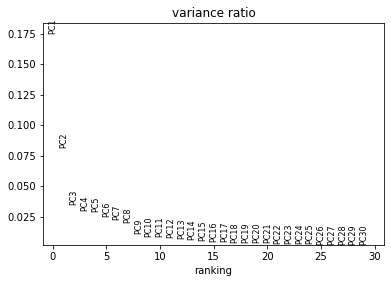

In [6]:
sc.pp.pca(adata, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata)

In [7]:
# Select number of PCs to use
N_PCS=15

Compare different embeddings based on previously defined annotation. 

In [8]:
#sc.pp.neighbors(adata,n_pcs = N_PCS,metric='correlation') 
#sc.tl.umap(adata)

In [9]:
#rcParams['figure.figsize']=(7,7)
#sc.pl.umap(adata,size=10,color=['pre_cell_type'])
#sc.pl.umap(adata,size=10,color=['file'])

In [10]:
sc.pp.neighbors(adata,n_pcs = N_PCS) 
sc.tl.umap(adata)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'

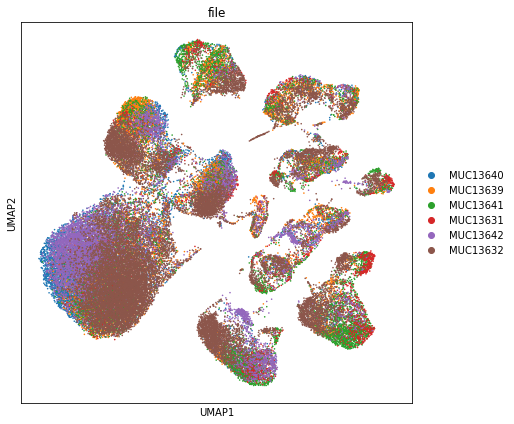

In [11]:
rcParams['figure.figsize']=(7,7)
#sc.pl.umap(adata,size=10,color=['pre_cell_type'])
sc.pl.umap(adata,size=10,color=['file'])

#### On scaled data

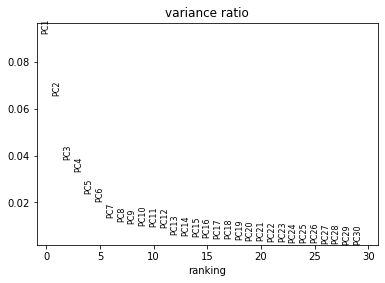

In [12]:
# Scale data and perform PCA
rcParams['figure.figsize']=(6,4)
adata_scl=adata.copy()
sc.pp.scale(adata_scl,max_value=10)
sc.pp.pca(adata_scl, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_scl)

In [13]:
#C: Can stay the same as above
N_PCS

15

In [14]:
# neighbours on scaled data
sc.pp.neighbors(adata_scl,n_pcs = N_PCS) 

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


In [15]:
# Umap on scaled data
sc.tl.umap(adata_scl)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


In [16]:
# Add scaled embedding to adata
adata.obsm['X_umap_scl']=adata_scl.obsm['X_umap']

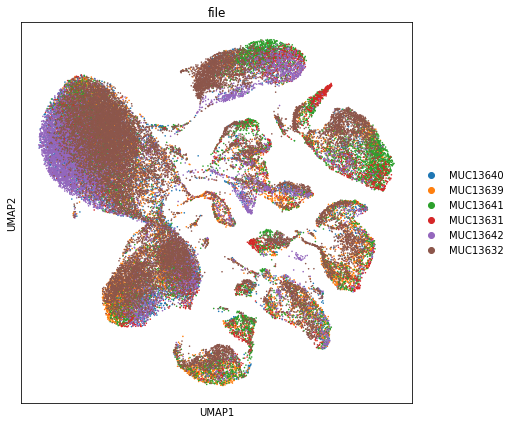

In [17]:
rcParams['figure.figsize']=(7,7)
#sc.pl.umap(adata_scl,size=10,color=['pre_cell_type'])
sc.pl.umap(adata_scl,size=10,color=['file'])

## Cell cycle
Performed separately for individual batches.

### Seurat/Scanpy - score by G2M and S

In [18]:
# Load mouse cell cycle genes
cell_cycle_mm=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/cell_cycle_mm_Macosko2015.tsv',sep='\t')

Use cell cycle genes that overlap HVGs (from different batches). Display these genes on HVG plots (with non-phase genes being marked as .NA).

Use G2/M and M gene sets for G2/M annotation and S gene set for S annotation.

G1/S N genes: 92 overlap var: 90 overlap hvg (all): 4
S N genes: 96 overlap var: 95 overlap hvg (all): 5
G2/M N genes: 127 overlap var: 126 overlap hvg (all): 15
M N genes: 143 overlap var: 142 overlap hvg (all): 12
M/G1 N genes: 108 overlap var: 105 overlap hvg (all): 3
N genes for scoring S: 5 and G2/M: 27


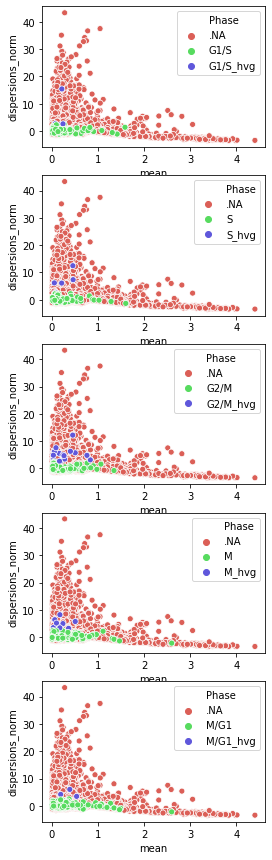

In [19]:
# How many of the cell cycle phase genes are present in HVG and in var and how variable they are
hvg=set(adata.var_names[adata.var.highly_variable])
i=0
rcParams['figure.figsize']=(4,15)
fig,axs=plt.subplots(5)
s_hvg=[]
g2m_hvg=[]
for phase in cell_cycle_mm.Phase.unique():
    genes_phase = set(cell_cycle_mm.query('Phase =="'+phase+'"').Gene)
    overlap_var = set(adata.var_names) & genes_phase
    overlap_hvg = hvg & genes_phase
    print(phase,'N genes:',len(genes_phase),'overlap var:',len(overlap_var),'overlap hvg (all):',len(overlap_hvg))
    phase_df=pd.DataFrame([phase]*len(overlap_var),index=overlap_var,columns=['Phase']).reindex(adata.var_names).fillna('.NA').sort_values('Phase')
    phase_df.loc[overlap_hvg,'Phase']=phase+'_hvg'
    phase_df['mean']=adata.var.means
    phase_df['dispersions_norm']=adata.var.dispersions_norm
    sb.scatterplot(x="mean", y="dispersions_norm", hue="Phase",data=phase_df,ax=axs[i],palette='hls')
    i+=1
    if phase == 'S':
        s_hvg.extend(overlap_hvg)
    if phase in ['G2/M','M']:
        g2m_hvg.extend(overlap_hvg)
        
print('N genes for scoring S:',len(s_hvg),'and G2/M:',len(g2m_hvg))

Cell cycle annotation

In [20]:
# Annotated cell cycle per batch
adata.obs['S_score']= np.zeros(adata.shape[0])
adata.obs['G2M_score'] = np.zeros(adata.shape[0])
adata.obs['phase'] = np.zeros(adata.shape[0])

for batch in enumerate(adata.obs['file'].cat.categories):
    batch=batch[1]
    idx = adata.obs.query('file=="'+batch+'"').index
    adata_tmp = adata[idx,:].copy()
    sc.tl.score_genes_cell_cycle(adata_tmp, s_genes=s_hvg, g2m_genes=g2m_hvg,use_raw=False)
    adata.obs.loc[idx,'S_score'] = adata_tmp.obs['S_score']
    adata.obs.loc[idx,'G2M_score'] = adata_tmp.obs['G2M_score']
    adata.obs.loc[idx,'phase'] = adata_tmp.obs['phase']
    
del adata_tmp

In [21]:
# Count of cells annotated to each phase
adata.obs['phase'].value_counts()

G1     24474
S      18149
G2M    14534
Name: phase, dtype: int64

Display cell cycle score distributions and annotation.

... storing 'phase' as categorical


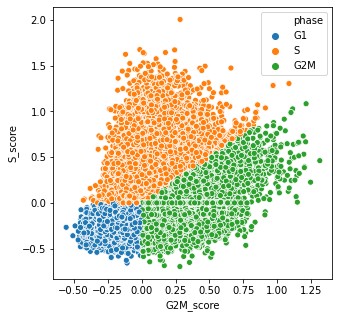

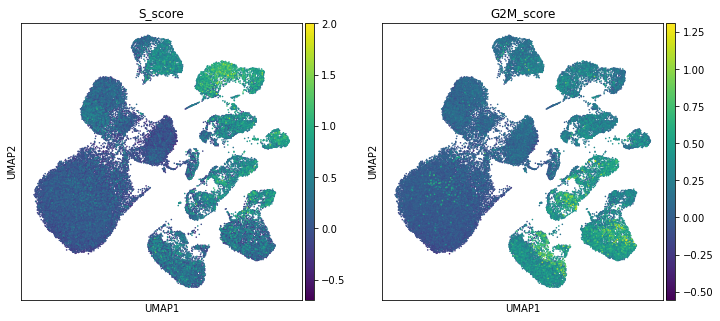

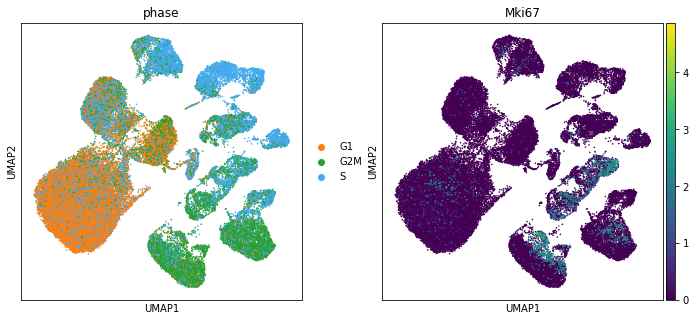

In [22]:
adata.uns['phase_colors']=['#ff7f0e', '#2ca02c','#46aaf0']

rcParams['figure.figsize']=(5,5)
sb.scatterplot(x='G2M_score',y='S_score',hue='phase',data=adata.obs)
sc.pl.umap(adata, color=['S_score', 'G2M_score'], size=10, use_raw=False)
sc.pl.umap(adata, color=['phase','Mki67'], size=10, use_raw=False)

#C: There might be some proliferating populations, but it is not very clear as many cells that probably are not proliferating (low Mki67 expression - not G2M) are annotated as cycling / G2M.

#### Check expression of S and G2M markers

In [23]:
set(s_hvg)&set(g2m_hvg)

{'Top2a'}

In [24]:
print('S and G2M marker set overlap %i out of %i S and %i G2M HVGs'%
      (len(set(s_hvg)&set(g2m_hvg)), len(s_hvg), len(g2m_hvg)))

S and G2M marker set overlap 1 out of 5 S and 27 G2M HVGs


S HVG


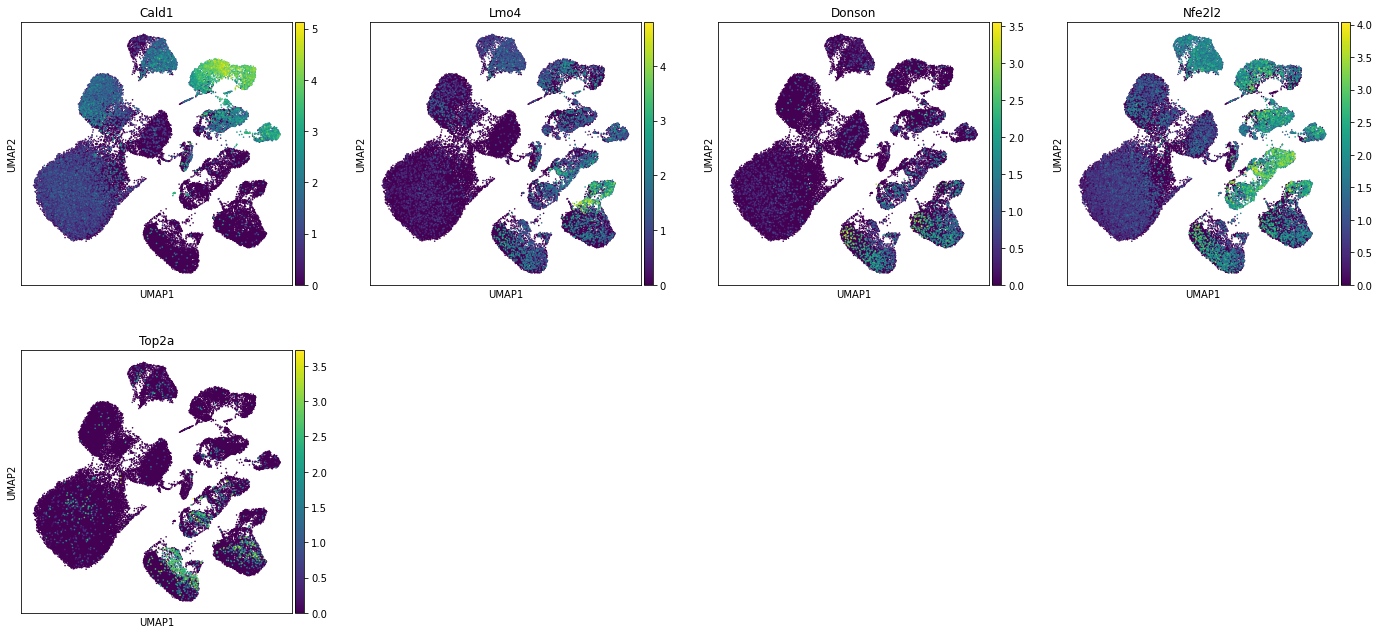

G2M HVG


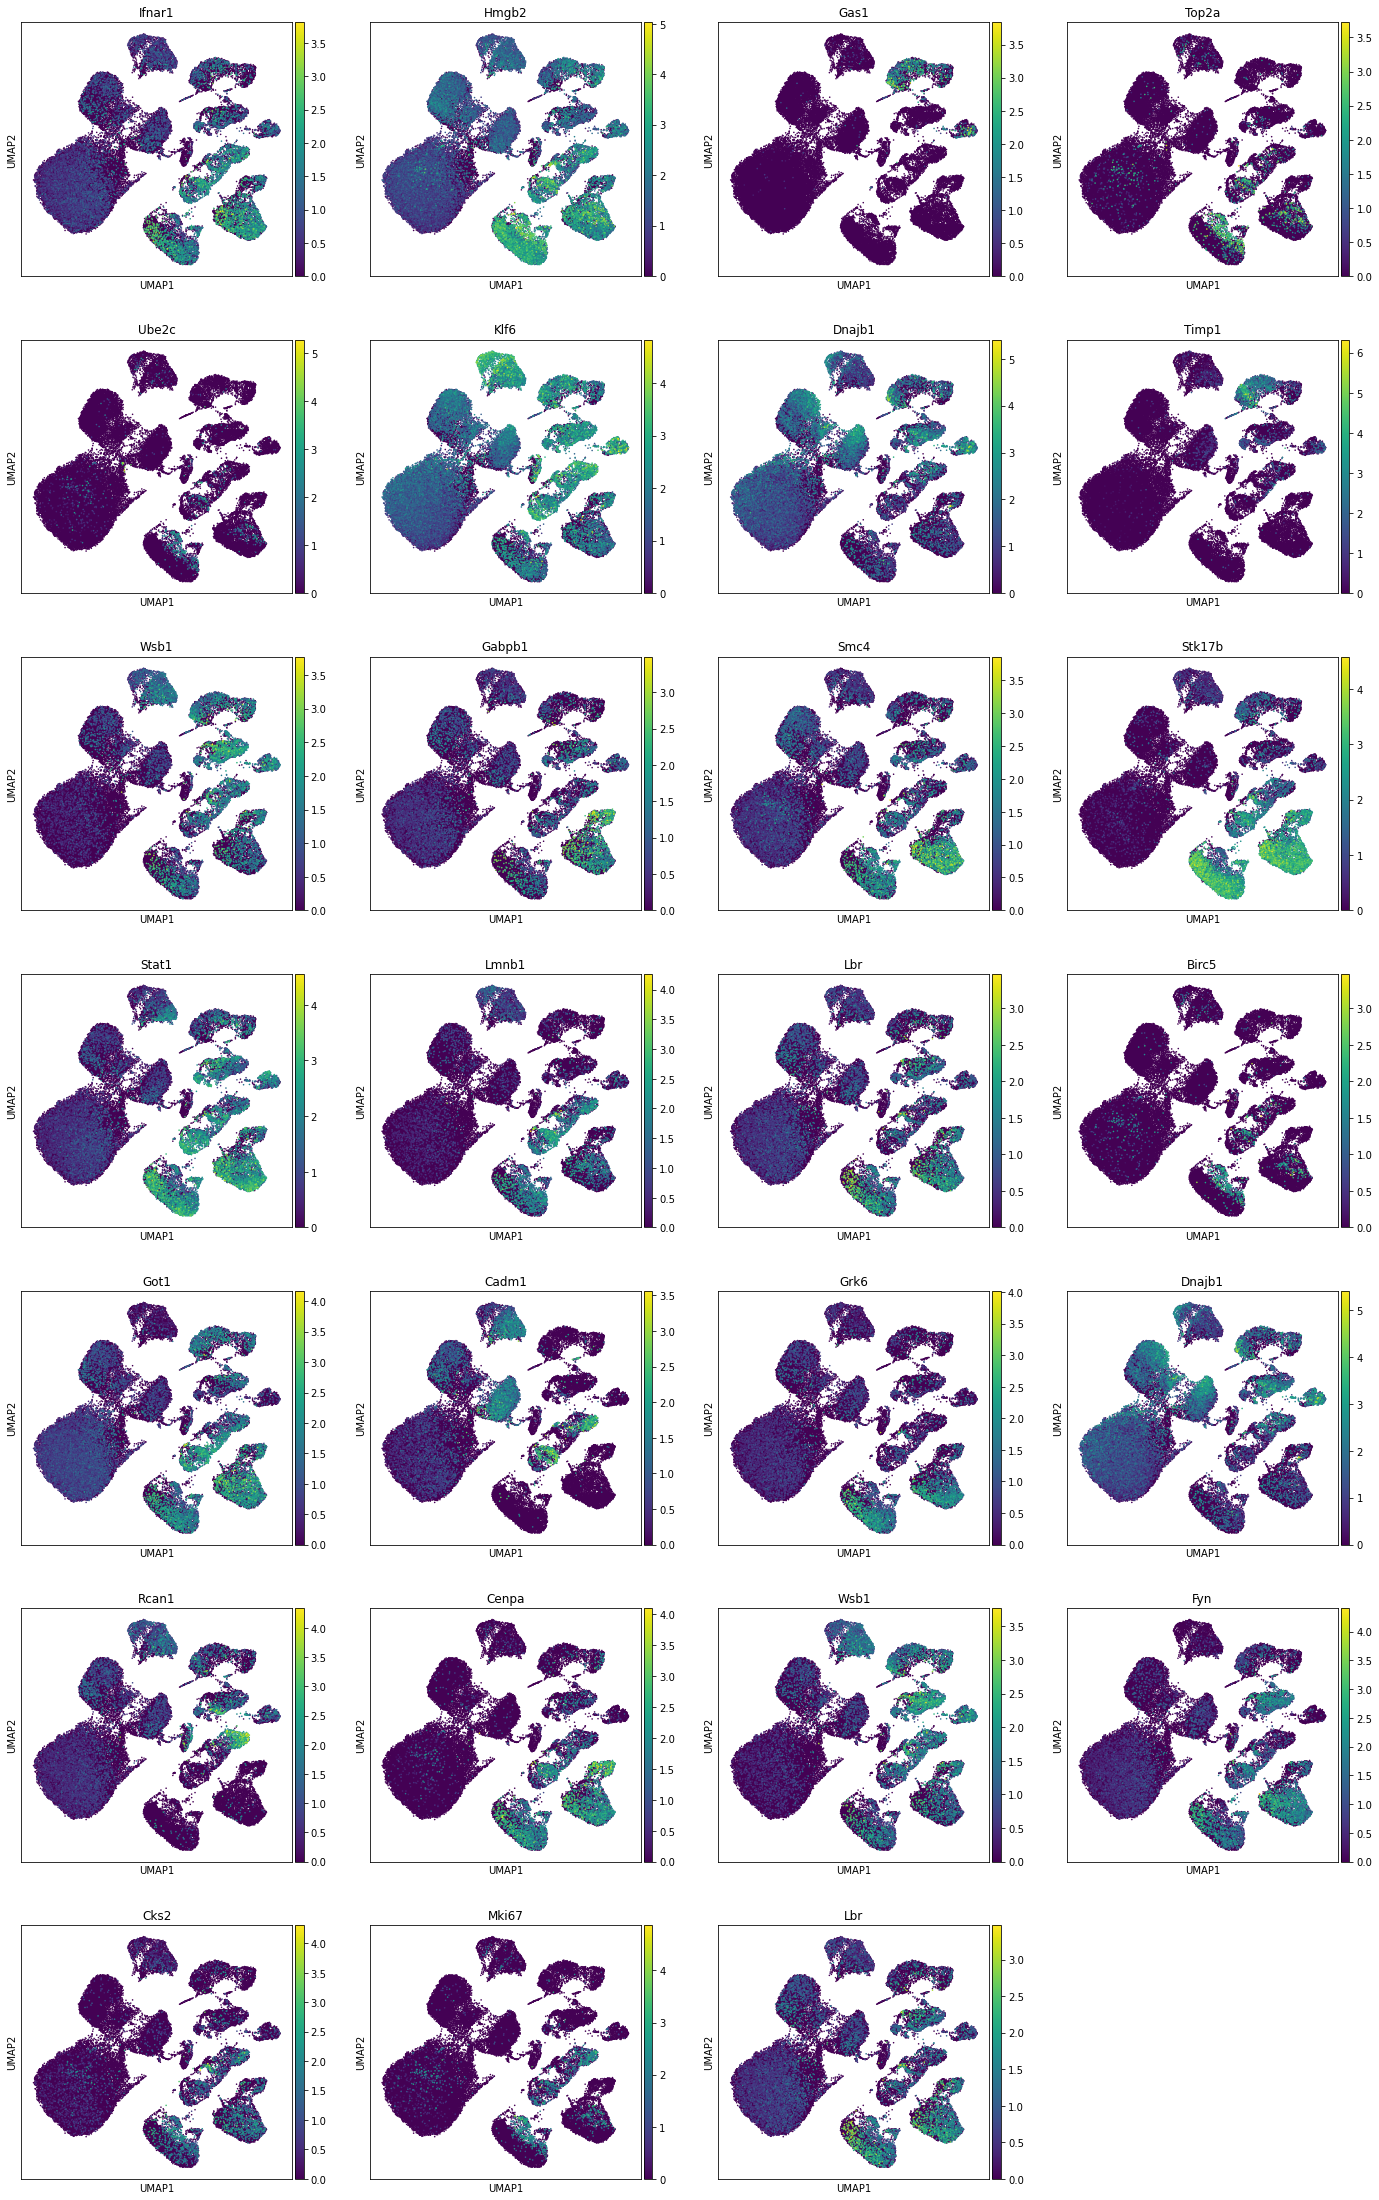

In [25]:
print('S HVG')
sc.pl.umap(adata, color=s_hvg, size=10, use_raw=False)
print('G2M HVG')
sc.pl.umap(adata, color=g2m_hvg, size=10, use_raw=False)

#C: The expression of G2M and S markers is not very consistent. Thus annotation that uses these markers is probably not reliable (-> use cyclone?).

 ### Cyclone - based on G1, S, and G2/M scores

Add gene Entrez IDs to adata in order to map genes to cell cycle database.

In [26]:
# Adata genes for R
genes=adata.var_names

#C: Current Ensembl release 101

In [27]:
%%R -i genes -o gene_ids
# Extract Ensembl gene IDs
mouse = useMart("ENSEMBL_MART_ENSEMBL", dataset = "mmusculus_gene_ensembl",version='Ensembl Genes 101',
                host="https://www.ensembl.org")
gene_ids = getBM(attributes = c("mgi_symbol",'ensembl_gene_id'), 
                 filters = "mgi_symbol", values = genes , mart = mouse, uniqueRows=FALSE)

In [28]:
# Add gene ids to adata, use only genes with unique mapped ensembl ids
gene_ids.drop_duplicates(subset='mgi_symbol', keep=False, inplace=True)
gene_ids.index=gene_ids.mgi_symbol
gene_ids=gene_ids.reindex(list(adata.var_names))
adata.var['EID']=gene_ids.ensembl_gene_id

In [29]:
# Prepare R data for cyclonee
x_mat=adata.X.T
gene_ids=adata.var.EID
batches=adata.obs.file
cells=adata.obs.index

In [32]:
%%R -i x_mat -i gene_ids -i batches -i cells -o cyclone_anno
# Cyclone cell scores, calculated separately for each batch
mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))
phases<-c()
s<-c()
g2m<-c()
g1<-c()
cells_order<-c()
for(batch in unique(batches)){
    # Select batch data
    x_mat_batch=x_mat[,batches==batch]
    print(batch,dim(x_mat_batch[1]))
    # Scores
    assignments <- cyclone(x_mat_batch, mm.pairs, gene.names=gene_ids,BPPARAM=MulticoreParam(workers = 16))
    phases<-c(phases,assignments$phases)
    s<-c(s,assignments$score$S)
    g2m<-c(g2m,assignments$score$G2M)
    g1<-c(g1,assignments$score$G1)
    # Save cell order
    cells_order<-c(cells_order,cells[batches==batch])
}
cyclone_anno<-data.frame(phase_cyclone=phases,s_cyclone=s,g2m_cyclone=g2m,g1_cyclone=g1)
rownames(cyclone_anno)<-cells_order

[1] "MUC13640"
[1] "MUC13639"
[1] "MUC13641"
[1] "MUC13631"
[1] "MUC13642"
[1] "MUC13632"


In [33]:
# Count of cells annotated to each phase
cyclone_anno.phase_cyclone.value_counts()

G1               56588
G2M                326
S                  238
NA_character_        5
Name: phase_cyclone, dtype: int64

In [34]:
# Add cyclone annotation to adata
cyclone_anno=cyclone_anno.reindex(adata.obs.index)
adata.obs=pd.concat([adata.obs,cyclone_anno],axis=1)

In [35]:
# replace NA annotation of cell phases
adata.obs.phase_cyclone.replace(r_na.NA_Character,'NA',inplace=True)
adata.obs.g1_cyclone.replace(r_na.NA_Character,'NA',inplace=True)
adata.obs.g2m_cyclone.replace(r_na.NA_Character,'NA',inplace=True)
adata.obs.s_cyclone.replace(r_na.NA_Character,'NA',inplace=True)

... storing 'phase_cyclone' as categorical
... storing 'EID' as categorical


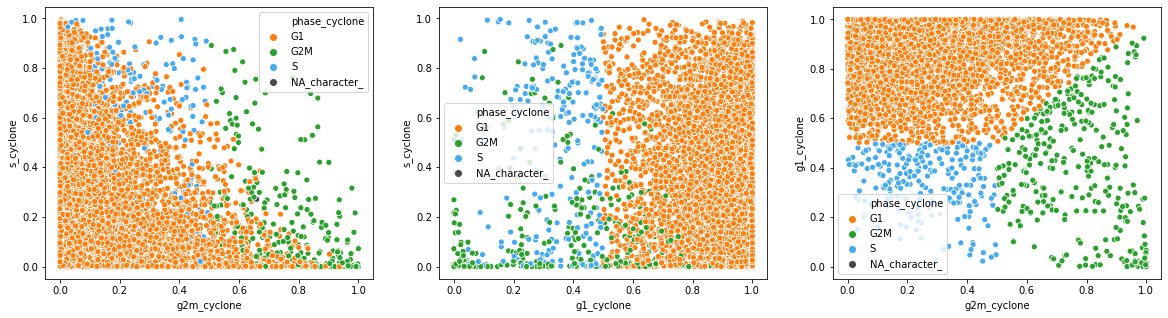

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


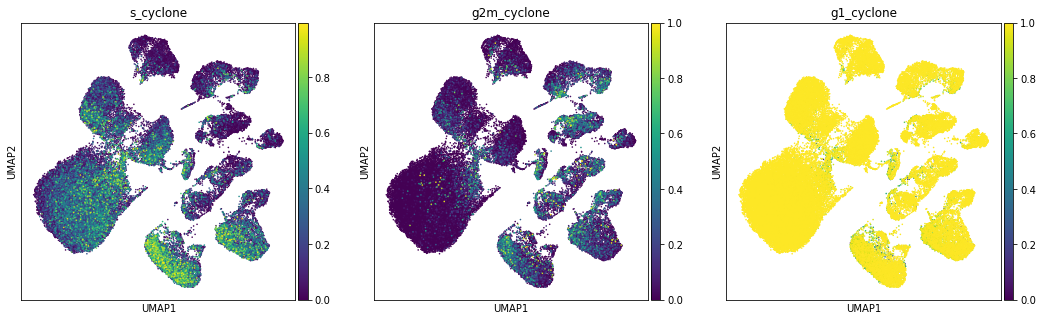

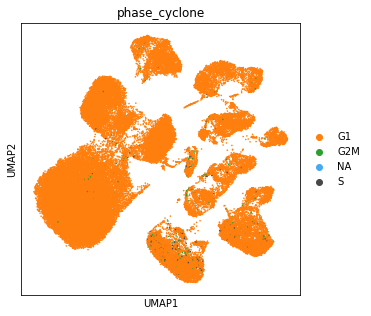

In [36]:
# Plot score distributions and cell assignment on UMAP
rcParams['figure.figsize']=(20,5)
fig,axs=plt.subplots(1,3)
palette=sb.color_palette(['#ff7f0e', '#2ca02c','#46aaf0','#484848'])
sb.scatterplot(x='g2m_cyclone',y='s_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[0],palette=palette)
sb.scatterplot(x='g1_cyclone',y='s_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[1],palette=palette)
sb.scatterplot(x='g2m_cyclone',y='g1_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[2],palette=palette)
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['s_cyclone', 'g2m_cyclone','g1_cyclone'], size=10, use_raw=False)
adata.uns['phase_cyclone_colors']=['#ff7f0e', '#2ca02c','#46aaf0','#484848']
sc.pl.umap(adata, color=['phase_cyclone'], size=10, use_raw=False)

#C: The cyclone may be leaving out proliferative cells.

#### Try on raw data without removed genes as suggested in manual.

In [38]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC136*/'
metadata=pd.read_excel('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='VSG')
samples=metadata.query('for_reference == False & tissue == "islet"')

# List all files
file_name='filtered_feature_bc_matrix.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)
# Subset to files used for reference        
files_subset=[]
for file in files:
    sample='_'.join([file.split('/')[i] for i in diff_path_idx])
    if any(sample_name in sample for sample_name in samples.sample_name.values):
        files_subset.append(file)
        
# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas=[]
file_diffs=[]
for file in files_subset:
    print('Reading file',file)
    #adatas.append(sc.read_h5ad(file))
    adatas.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata_raw = ann.AnnData.concatenate( *adatas,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13640/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13639/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13641/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13631/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13642/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13632/filtered_feature_bc_matrix.h5ad


In [39]:
# Subest to retained cells
adata_raw=adata_raw[adata.obs_names,:]

In [40]:
# Adata genes for R
genes=adata_raw.var_names

#C: Current Ensembl release 101

In [41]:
%%R -i genes -o gene_ids
# Extract Ensembl gene IDs
mouse = useMart("ENSEMBL_MART_ENSEMBL", dataset = "mmusculus_gene_ensembl",version='Ensembl Genes 101',
                host="https://www.ensembl.org")
gene_ids = getBM(attributes = c("mgi_symbol",'ensembl_gene_id'), 
                 filters = "mgi_symbol", values = genes , mart = mouse, uniqueRows=FALSE)

In [42]:
# Add gene ids to adata, use only genes with unique mapped ensembl ids
gene_ids.drop_duplicates(subset='mgi_symbol', keep=False, inplace=True)
gene_ids.index=gene_ids.mgi_symbol
gene_ids=gene_ids.reindex(list(adata_raw.var_names))
adata_raw.var['EID']=gene_ids.ensembl_gene_id

Trying to set attribute `.var` of view, copying.


In [43]:
# Prepare R data for cyclonee
x_mat=adata_raw.X.T
gene_ids=adata_raw.var.EID
batches=adata_raw.obs.file
cells=adata_raw.obs.index

In [ ]:
%%R -i x_mat -i gene_ids -i batches -i cells -o cyclone_anno
# Cyclone cell scores, calculated separately for each batch
mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))
phases<-c()
s<-c()
g2m<-c()
g1<-c()
cells_order<-c()
for(batch in unique(batches)){
    # Select batch data
    x_mat_batch=x_mat[,batches==batch]
    print(batch,dim(x_mat_batch[1]))
    # Scores
    assignments <- cyclone(x_mat_batch, mm.pairs, gene.names=gene_ids,BPPARAM=MulticoreParam(workers = 16))
    phases<-c(phases,assignments$phases)
    s<-c(s,assignments$score$S)
    g2m<-c(g2m,assignments$score$G2M)
    g1<-c(g1,assignments$score$G1)
    # Save cell order
    cells_order<-c(cells_order,cells[batches==batch])
}
cyclone_anno<-data.frame(phase_cyclone=phases,s_cyclone=s,g2m_cyclone=g2m,g1_cyclone=g1)
rownames(cyclone_anno)<-cells_order

[1] "MUC13640"
[1] "MUC13639"
[1] "MUC13641"
[1] "MUC13631"
[1] "MUC13642"
[1] "MUC13632"


In [51]:
# Count of cells annotated to each phase
cyclone_anno.phase_cyclone.value_counts()

G1               56575
G2M                328
S                  249
NA_character_        5
Name: phase_cyclone, dtype: int64

In [74]:
# Add cyclone annotation to adata
cyclone_anno=cyclone_anno.reindex(adata_raw.obs.index)
adata_raw.obs=pd.concat([adata_raw.obs,cyclone_anno],axis=1)

In [75]:
# replace NA annotation of cell phases
adata_raw.obs.phase_cyclone.replace(r_na.NA_Character,'NA',inplace=True)
adata_raw.obs.g1_cyclone.replace(r_na.NA_Character,'NA',inplace=True)
adata_raw.obs.g2m_cyclone.replace(r_na.NA_Character,'NA',inplace=True)
adata_raw.obs.s_cyclone.replace(r_na.NA_Character,'NA',inplace=True)

In [76]:
adata_raw.obsm['X_umap']=adata.obsm['X_umap'].copy()

... storing 'phase_cyclone' as categorical


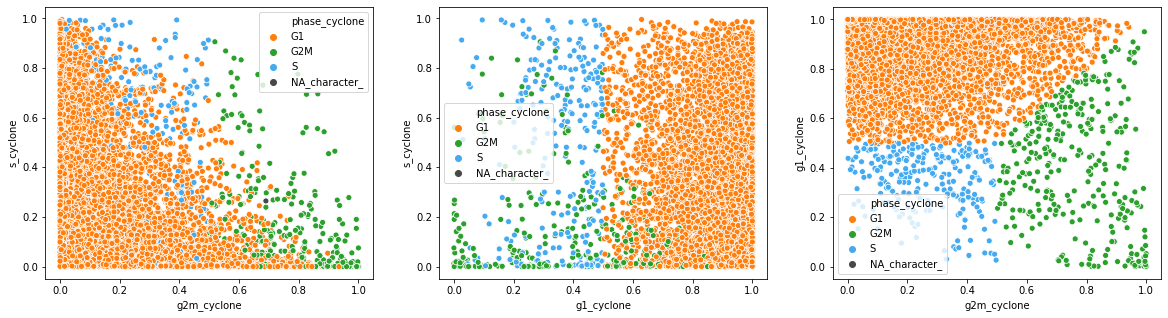

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


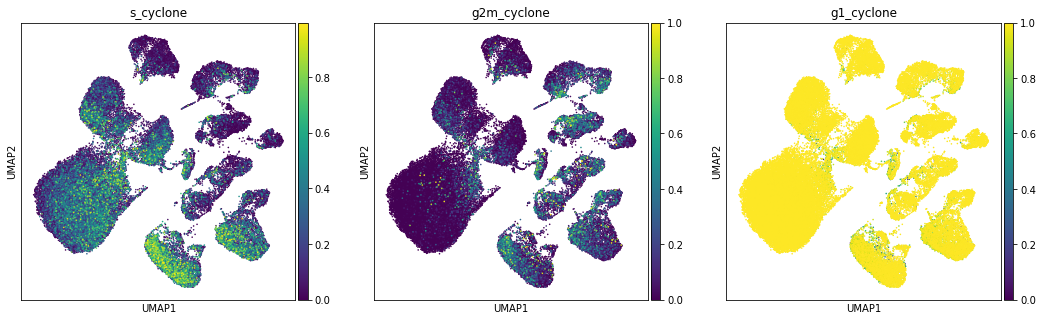

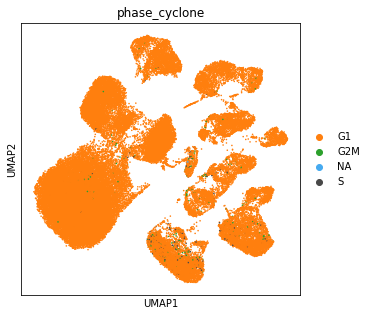

In [77]:
# Plot score distributions and cell assignment on UMAP
rcParams['figure.figsize']=(20,5)
fig,axs=plt.subplots(1,3)
palette=sb.color_palette(['#ff7f0e', '#2ca02c','#46aaf0','#484848'])
sb.scatterplot(x='g2m_cyclone',y='s_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[0],palette=palette)
sb.scatterplot(x='g1_cyclone',y='s_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[1],palette=palette)
sb.scatterplot(x='g2m_cyclone',y='g1_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[2],palette=palette)
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata_raw, color=['s_cyclone', 'g2m_cyclone','g1_cyclone'], size=10, use_raw=False)
adata_raw.uns['phase_cyclone_colors']=['#ff7f0e', '#2ca02c','#46aaf0','#484848']
sc.pl.umap(adata_raw, color=['phase_cyclone'], size=10, use_raw=False)

#C: Using raw data (that has all genes (and is not normalised)) does not improve (or importantly change) the cell type annotation results.

#C: Decide to use cyclone (more conservative) as gene set scoring annotation is annotationg too many cells as cycling. 

## Save intermediate results before cell type annotation

In [ ]:
if SAVE:
    h.save_h5ad(adata, shared_folder+"data_annotated.h5ad",unique_id2=UID2)